## Required Libraries

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os
import torchvision
import torchvision.transforms.functional as TF
import random
import glob
from torchmetrics import JaccardIndex
from torchmetrics.classification import Dice

In [162]:
import sys
sys.path.append('../src/')
import preprocess
#import json2mask
import constant
from model import Unet

## PARAMETERS

In [163]:
VALID_SIZE = 0.3
TEST_SIZE  = 0.1
BATCH_SIZE = 4
EPOCHS = 20
CUDA = False
INPUT_SHAPE = (224, 224)
N_CLASSES = 2

## DIRECTORIES

In [164]:
SRC_DIR=os.getcwd()
ROOT_DIR=os.path.join(SRC_DIR,'..')
IMAGE_DIR=os.path.join(ROOT_DIR,'images')
MASK_DIR=os.path.join(ROOT_DIR,"masks")

In [165]:
ROOT_DIR='C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\'

In [166]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [167]:
image_paths=os.listdir('C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images')
mask_paths=os.listdir('C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks')
line_mask_paths=os.listdir('C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks')

In [168]:
for i in range(len(image_paths)):
    image_paths[i]=ROOT_DIR+"images\\"+image_paths[i]

In [169]:
for i in range(len(line_mask_paths)):
    line_mask_paths[i]=ROOT_DIR+"line_masks\\"+line_mask_paths[i]

In [170]:
image_paths

['C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002387.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002403.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002411.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002419.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002427.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002435.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002443.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002451.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internsh

In [171]:
mask_paths

['cfcu_002387.png',
 'cfcu_002403.png',
 'cfcu_002411.png',
 'cfcu_002419.png',
 'cfcu_002427.png',
 'cfcu_002435.png',
 'cfcu_002443.png',
 'cfcu_002451.png',
 'cfcu_002459.png',
 'cfcu_002467.png',
 'cfcu_002475.png',
 'cfcu_002483.png',
 'cfcu_002491.png',
 'cfcu_002499.png']

In [172]:
line_mask_paths

['C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002387.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002403.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002411.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002419.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002427.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002435.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002443.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\cfcu_002451.png',
 'C:\\Users\\Beytullah\\Documents\\GitHu

## Json2Mask

In [173]:
for i in range(len(image_paths)):
    mask_paths[i]=ROOT_DIR+"masks\\"+mask_paths[i]

In [174]:
mask=plt.imread(mask_paths[0])

In [175]:
mask_paths

['C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002387.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002403.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002411.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002419.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002427.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002435.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002443.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002451.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Proje

In [176]:
def visualize_example_fs_mask_pair(image_paths,mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(mask_paths[random_idx])
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    

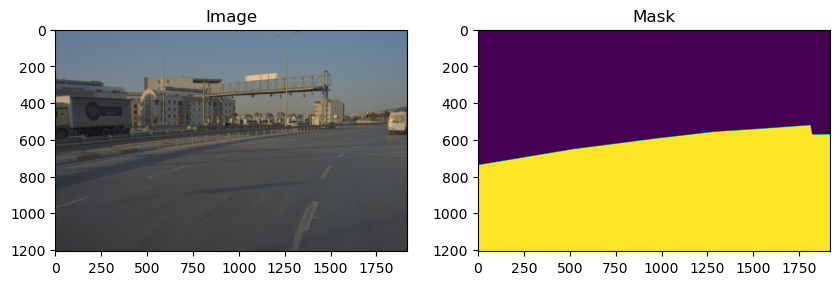

In [177]:
visualize_example_fs_mask_pair(image_paths,mask_paths)

In [219]:
def visualize_example_line_mask_pair(image_paths,line_mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(line_mask_paths[random_idx])
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    

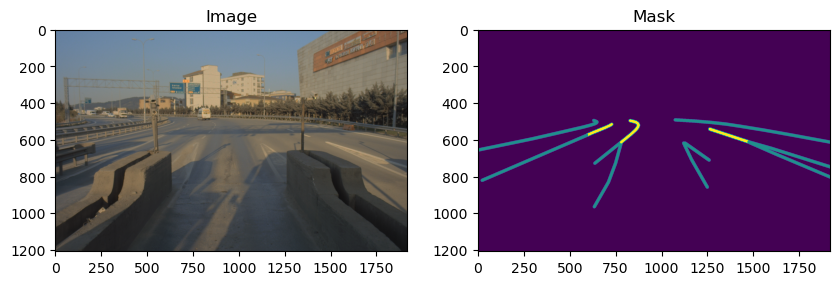

In [220]:
visualize_example_line_mask_pair(image_paths,line_mask_paths)

In [221]:
image=plt.imread(image_paths[4])
mask=plt.imread(mask_paths[4])

In [180]:
print(f"Shape of the mask: {mask.shape}")
print(f"Shape of the images: {image.shape}")

Shape of the mask: (1208, 1920)
Shape of the images: (1208, 1920, 3)


In [181]:
for i,unique_val in enumerate(np.unique(mask)):
    print(i,unique_val)

0 0.0
1 0.003921569


In [182]:
mask

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157]], dtype=float32)

# Preprocessing 

### torchlike_data() method

In [183]:
image=plt.imread(image_paths[0])

In [184]:
image_before_torchlike=image
print(f"Image shapes before torchlike_data() method {image_before_torchlike.shape}")

Image shapes before torchlike_data() method (1208, 1920, 3)


In [185]:
torch_like_data_example=preprocess.torchlike_data(image)

In [186]:
print(f"Image shapes before torchlike_data() method {torch_like_data_example.shape}")

Image shapes before torchlike_data() method (3, 1208, 1920)


We can see that at first our image has HeightxWidthxShape data format. Pytorch wants our images as ChannelxHeightxWidth format.

### onehot_encoder() method

One hot encoding is a method that provides us to convert categorical data into vectors. Fro now we have 2 categorical value wihich is pixel belong to freespace or not.

Returns a matrix containing as many channels as the number of unique values ​​in the input Matrix, where each channel represents a unique class.

In [187]:
example_mask=plt.imread(mask_paths[3])
one_hot_encoded=preprocess.one_hot_encoder(example_mask,n_class=2)

In [188]:
print(f"The dimensions of one hot encoded mask is {one_hot_encoded.shape}")

The dimensions of one hot encoded mask is (1208, 1920, 2)


## tensorize_image method

In [189]:
tensorized_images=preprocess.tensorize_image(image_paths,(224,224))

In [190]:
tensorized_images[0].shape

torch.Size([3, 224, 224])

In [191]:
tensorized_images[0]

tensor([[[ 68.,  67.,  67.,  ..., 154., 154., 155.],
         [ 68.,  68.,  71.,  ..., 155., 157., 156.],
         [ 68.,  70.,  68.,  ..., 154., 159., 155.],
         ...,
         [ 64.,  64.,  60.,  ...,  66.,  55.,  55.],
         [ 64.,  63.,  64.,  ...,  54.,  61.,  57.],
         [ 65.,  66.,  64.,  ...,  61.,  61.,  56.]],

        [[ 62.,  61.,  62.,  ..., 144., 141., 142.],
         [ 62.,  62.,  62.,  ..., 143., 144., 142.],
         [ 63.,  62.,  63.,  ..., 141., 143., 141.],
         ...,
         [ 53.,  56.,  51.,  ...,  53.,  49.,  51.],
         [ 53.,  56.,  56.,  ...,  49.,  53.,  50.],
         [ 54.,  55.,  58.,  ...,  54.,  52.,  49.]],

        [[ 56.,  56.,  57.,  ..., 126., 126., 127.],
         [ 59.,  57.,  60.,  ..., 128., 126., 127.],
         [ 56.,  57.,  58.,  ..., 129., 129., 126.],
         ...,
         [ 46.,  50.,  45.,  ...,  48.,  44.,  46.],
         [ 48.,  50.,  48.,  ...,  44.,  46.,  44.],
         [ 48.,  47.,  50.,  ...,  46.,  46.,  42.]]]

## tensorize_mask.() method

In [192]:
tensorized_masks=preprocess.tensorize_mask(mask_paths,(constant.HEIGHT,constant.WIDTH),n_class=2)

In [193]:
tensorized_masks.shape

torch.Size([14, 2, 224, 224])

In [194]:
tensorized_masks[3]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

## Model

In [195]:
model=Unet(in_channels=3,out_channels=2)

In [196]:
outputs=model.forward(tensorized_images)

In [197]:
outputs[0].shape

torch.Size([2, 224, 224])

In [198]:
tensorized_images.shape

torch.Size([14, 3, 224, 224])

In [199]:
outputs[5]

tensor([[[ 0.1107, -0.0331, -0.3937,  ..., -0.5771, -0.2772,  0.6814],
         [ 0.2928, -0.2827, -0.2817,  ..., -0.0915,  0.1139,  0.6816],
         [ 0.1394, -0.2723, -0.1779,  ..., -0.0724,  0.4563,  0.0812],
         ...,
         [ 0.0335,  0.1323,  0.0423,  ...,  0.0890,  0.0484,  0.0357],
         [ 0.2337, -0.1852, -0.2103,  ..., -0.0080,  0.1061,  0.2654],
         [ 0.4151, -0.1865, -0.2242,  ..., -0.0057, -0.1431,  0.2865]],

        [[-0.6012, -0.7756, -0.8031,  ..., -0.8217, -0.6897,  0.0732],
         [-0.4497, -1.3332, -0.6665,  ..., -0.5658, -1.1157, -0.4828],
         [-0.3022, -0.8567, -0.5190,  ..., -0.1115, -0.4187, -0.0657],
         ...,
         [-0.0543, -0.4440, -0.3346,  ..., -0.4691, -0.2225, -0.2135],
         [-0.2232, -0.4654, -0.0799,  ..., -0.3044, -0.3028, -0.5540],
         [ 0.0317, -0.3472, -0.3771,  ..., -0.2691, -0.1202, -0.4241]]],
       grad_fn=<SelectBackward0>)

In [200]:
outputs[5].shape

torch.Size([2, 224, 224])

## Model Training

In [201]:
# PREPARE IMAGE AND MASK LISTS
image_path_list = glob.glob(os.path.join("C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\", '*'))
image_path_list.sort()

mask_path_list = glob.glob(os.path.join("C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\", '*'))
mask_path_list.sort()


In [202]:
# DATA CHECK
preprocess.image_mask_check(image_path_list, mask_path_list)

True

## Train, Valid and Test Data Split

In [203]:
indices = np.random.permutation(len(image_path_list))

# DEFINE TEST AND VALID INDICES
test_ind  = int(len(indices) * TEST_SIZE)
valid_ind = int(test_ind + len(indices) * VALID_SIZE)

# SLICE TEST DATASET FROM THE WHOLE DATASET
test_input_path_list = image_path_list[:test_ind]
test_label_path_list = mask_path_list[:test_ind]

# SLICE VALID DATASET FROM THE WHOLE DATASET
valid_input_path_list = image_path_list[test_ind:valid_ind]
valid_label_path_list = mask_path_list[test_ind:valid_ind]

# SLICE TRAIN DATASET FROM THE WHOLE DATASET
train_input_path_list = image_path_list[valid_ind:]
train_label_path_list = mask_path_list[valid_ind:]

# DEFINE STEPS PER EPOCH
steps_per_epoch = len(train_input_path_list)//BATCH_SIZE
print(len(train_input_path_list))

9


In [204]:
print(len(train_input_path_list)//BATCH_SIZE)

2


## Train Freespace Segmentation Model

In [205]:
model=Unet(in_channels=3,out_channels=2)

In [206]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [207]:
outputs

tensor([[[[ 4.7162e-03,  5.1486e-02,  9.3710e-02,  ..., -6.2859e-01,
            1.8998e-01,  9.0377e-01],
          [-2.9338e-02, -5.3895e-01, -1.7015e-01,  ..., -5.5705e-01,
            2.8695e-01,  9.3119e-01],
          [-1.1840e-01,  1.5749e-01,  4.6258e-02,  ..., -6.8112e-01,
            4.5254e-01,  3.0649e-01],
          ...,
          [ 1.5104e-02,  2.1281e-01,  9.9848e-02,  ...,  1.4641e-01,
           -8.8602e-02, -6.1606e-02],
          [ 1.4769e-01, -1.8008e-01, -3.3814e-01,  ..., -7.6245e-02,
            1.2563e-01,  2.8208e-01],
          [ 3.3490e-01, -1.1511e-01, -1.3895e-01,  ..., -9.3692e-02,
           -1.3930e-01,  3.4041e-01]],

         [[-3.5638e-01, -3.1193e-01, -2.8849e-01,  ..., -1.0591e+00,
           -7.3637e-01,  2.5045e-01],
          [-3.4622e-01, -4.9778e-01, -2.3129e-01,  ..., -8.7578e-01,
           -1.3345e+00, -5.6019e-01],
          [-2.2308e-01, -5.5166e-01, -2.0862e-01,  ..., -7.3928e-02,
           -5.0942e-01, -1.0051e-02],
          ...,
     

In [208]:
len(valid_input_path_list)

4

In [209]:
if CUDA:
    model = model.cuda()


# TRAINING THE NEURAL NETWORK
for epoch in range(EPOCHS):
    running_loss = 0
    for ind in range(steps_per_epoch):
        batch_input_path_list = train_input_path_list[BATCH_SIZE*ind:BATCH_SIZE*(ind+1)]
        batch_label_path_list = train_label_path_list[BATCH_SIZE*ind:BATCH_SIZE*(ind+1)]
        batch_input = preprocess.tensorize_image(batch_input_path_list, INPUT_SHAPE,CUDA)
        batch_label = preprocess.tensorize_mask(batch_label_path_list, INPUT_SHAPE, N_CLASSES, CUDA)
        optimizer.zero_grad()

        outputs = model.forward(batch_input)
       
        loss = criterion(outputs, batch_label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
     
        if ind == steps_per_epoch-1:
            print('training loss on epoch {}: {}'.format(epoch, running_loss))
            """
            val_loss = 0
            for (valid_input_path, valid_label_path) in zip(valid_input_path_list, valid_label_path_list):
                batch_input = preprocess.tensorize_image(valid_input_path, INPUT_SHAPE, CUDA)
                batch_label = preprocess.tensorize_mask(valid_label_path, INPUT_SHAPE, N_CLASSES, CUDA)
                outputs = model.forward(batch_input)
                loss = criterion(outputs, batch_label)
                val_loss += loss
                break

            print('validation loss on epoch {}: {}'.format(epoch, val_loss))
            """
        

training loss on epoch 0: 1.3316277861595154
training loss on epoch 1: 1.2817845940589905
training loss on epoch 2: 1.2080731391906738
training loss on epoch 3: 1.137625515460968
training loss on epoch 4: 1.0793362855911255
training loss on epoch 5: 1.0325153470039368
training loss on epoch 6: 0.993491917848587
training loss on epoch 7: 0.9597294628620148
training loss on epoch 8: 0.9300789535045624
training loss on epoch 9: 0.9038743674755096
training loss on epoch 10: 0.880489319562912
training loss on epoch 11: 0.8592270016670227
training loss on epoch 12: 0.8394584059715271
training loss on epoch 13: 0.8209016919136047
training loss on epoch 14: 0.8033142387866974
training loss on epoch 15: 0.7866376638412476
training loss on epoch 16: 0.7708140909671783
training loss on epoch 17: 0.7557481825351715
training loss on epoch 18: 0.7413293421268463
training loss on epoch 19: 0.7273456454277039


## Save Model

In [210]:
torch.save(model,"segmentation_model.pth")

# Train Line Segmentation Model

In [139]:
# PREPARE IMAGE AND MASK LISTS
image_line_path_list = glob.glob(os.path.join("C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\", '*'))
image_line_path_list.sort()

mask_line_path_list = glob.glob(os.path.join("C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\line_masks\\", '*'))
mask_line_path_list.sort()


In [140]:
# DATA CHECK
preprocess.image_mask_check(image_line_path_list, mask_line_path_list)

True

In [141]:
line_segmentation_model=Unet(in_channels=3,out_channels=3)

In [142]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(line_segmentation_model.parameters(), lr=0.001, momentum=0.9)


In [143]:
indices = np.random.permutation(len(image_line_path_list))

# DEFINE TEST AND VALID INDICES
test_ind  = int(len(indices) * TEST_SIZE)
valid_ind = int(test_ind + len(indices) * VALID_SIZE)

# SLICE TEST DATASET FROM THE WHOLE DATASET
test_input_path_list = image_line_path_list[:test_ind]
test_label_path_list = mask_line_path_list[:test_ind]

# SLICE VALID DATASET FROM THE WHOLE DATASET
valid_input_path_list = image_line_path_list[test_ind:valid_ind]
valid_label_path_list = mask_line_path_list[test_ind:valid_ind]

# SLICE TRAIN DATASET FROM THE WHOLE DATASET
train_input_path_list = image_line_path_list[valid_ind:]
train_label_path_list = mask_line_path_list[valid_ind:]

# DEFINE STEPS PER EPOCH
steps_per_epoch = len(train_input_path_list)//BATCH_SIZE
print(len(train_input_path_list))

9


In [144]:
if CUDA:
    line_segmentation_model = line_segmentation_model.cuda()


# TRAINING THE NEURAL NETWORK
for epoch in range(EPOCHS):
    running_loss = 0
    for ind in range(steps_per_epoch):
        batch_input_path_list = train_input_path_list[BATCH_SIZE*ind:BATCH_SIZE*(ind+1)]
        batch_label_path_list = train_label_path_list[BATCH_SIZE*ind:BATCH_SIZE*(ind+1)]
        batch_input = preprocess.tensorize_image(batch_input_path_list, INPUT_SHAPE,CUDA)
        batch_label = preprocess.tensorize_mask(batch_label_path_list, INPUT_SHAPE, 3, CUDA)
        optimizer.zero_grad()

        outputs = line_segmentation_model.forward(batch_input)
       
        loss = criterion(outputs, batch_label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
     
        if ind == steps_per_epoch-1:
            print('training loss on epoch {}: {}'.format(epoch, running_loss))
            """
            val_loss = 0
            for (valid_input_path, valid_label_path) in zip(valid_input_path_list, valid_label_path_list):
                batch_input = preprocess.tensorize_image(valid_input_path, INPUT_SHAPE, CUDA)
                batch_label = preprocess.tensorize_mask(valid_label_path, INPUT_SHAPE, N_CLASSES, CUDA)
                outputs = model.forward(batch_input)
                loss = criterion(outputs, batch_label)
                val_loss += loss
                break

            print('validation loss on epoch {}: {}'.format(epoch, val_loss))
            """
        

training loss on epoch 0: 2.815886974334717
training loss on epoch 1: 2.733829617500305
training loss on epoch 2: 2.5958852767944336
training loss on epoch 3: 2.428149938583374
training loss on epoch 4: 2.247418999671936
training loss on epoch 5: 2.0636733770370483
training loss on epoch 6: 1.8838112354278564
training loss on epoch 7: 1.7127275466918945
training loss on epoch 8: 1.553094744682312
training loss on epoch 9: 1.4064415097236633
training loss on epoch 10: 1.273771047592163
training loss on epoch 11: 1.1554211378097534
training loss on epoch 12: 1.0508041381835938
training loss on epoch 13: 0.9588261842727661
training loss on epoch 14: 0.8783719539642334
training loss on epoch 15: 0.808359682559967
training loss on epoch 16: 0.7476133108139038
training loss on epoch 17: 0.694924920797348
training loss on epoch 18: 0.6491883397102356
training loss on epoch 19: 0.6094320714473724


In [151]:
torch.save(line_segmentation_model,"line_segmentation_model.pth")

# Inference from Trained Model

In [211]:
tensorized_test_images=preprocess.tensorize_image(test_input_path_list,INPUT_SHAPE)

In [212]:
test_outputs=model(tensorized_test_images)

In [213]:
pred_test=test_outputs[0]
pred_test=torch.sigmoid(pred_test)
print(pred_test.shape)
pred_test=pred_test[0].detach().numpy()
pred_test=pred_test>0.50
print(pred_test.shape)

torch.Size([2, 224, 224])
(224, 224)


In [214]:
pred_test

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

Text(0.5, 1.0, 'Prediction')

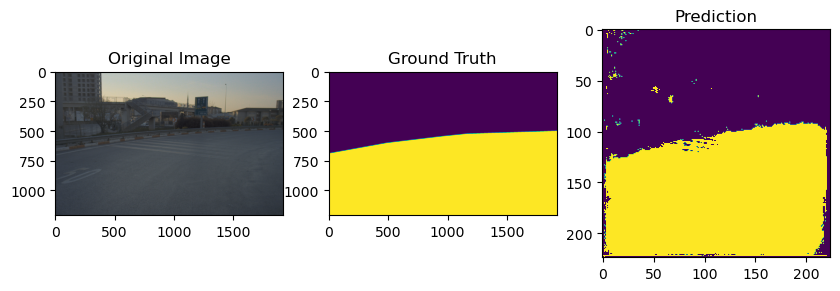

In [215]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(10,10))
axs[0].imshow(plt.imread(test_input_path_list[0]))
axs[0].set_title('Original Image')
axs[1].imshow(plt.imread(test_label_path_list[0]))
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_test)
axs[2].set_title('Prediction')

## Evaluation

### IOU Score With Jaccard Index

In [216]:
    target=preprocess.tensorize_mask(test_label_path_list,INPUT_SHAPE,2)
    pred_test=test_outputs[0]
    pred_test=torch.sigmoid(pred_test)
    jaccard_index=JaccardIndex(task='binary',num_classes=2)
    jaccard_index(pred_test,target[0])
    
    

tensor(0.9163)